In [1]:
# 2025-4-10 run it in "python 3" based env on ins-gl-pt-gpu# 24-2c94136-3env-j4-l4-test with 1 l4 gpu
# test cubediff 


# CubeDiff Example Notebook

This notebook demonstrates the CubeDiff architecture for generating high-quality 360° panoramas from text prompts and narrow field-of-view images.

The notebook covers:
1. Installation and setup
2. Testing the cubemap conversion functions
3. Loading model components
4. Testing the synchronized GroupNorm and inflated attention
5. Running inference with a pre-trained model

## 1. Installation and Setup

First, let's install the required packages and import the necessary modules.

In [2]:
# !which pip

In [3]:
# !pip install diffusers==0.24.0 transformers==4.36.2 torch==2.1.2 torchvision==0.16.2 accelerate==0.25.0 \
    # opencv-python==4.8.1.78 matplotlib==3.8.2 tqdm==4.66.1 einops==0.7.0

# !pip install diffusers==0.24.0 transformers==4.36.2 torch==2.1.2 torchvision==0.16.2 accelerate==0.25.0 \
#     opencv-python==4.8.1.78 matplotlib==3.8.2 tqdm==4.66.1 einops==0.7.0 huggingface_hub==0.19.4 opencv-python

In [4]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer

import cubediff_visualize as viz

In [5]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print the number of available GPUs
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Using device: cuda
Number of available GPUs: 1
GPU 0: NVIDIA L4


## 2. Testing the Cubemap Conversion Functions

Now let's implement and test the equirectangular to cubemap conversion functions.

In [6]:
# Import the cubemap utility functions
from cubediff_utils import equirect_to_cubemap, cubemap_to_equirect, add_cubemap_positional_encodings

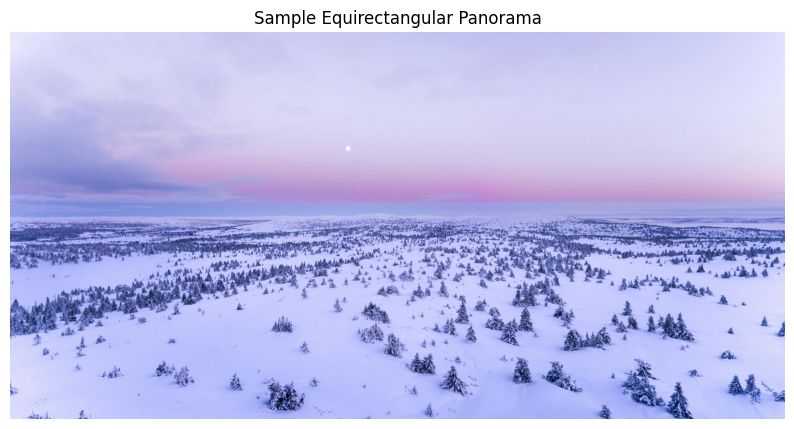

In [7]:
# Download a sample panorama image
# sample_url = "https://cdn.polyhaven.com/asset_img/renders/vieux_port_marseille/360_equirectangular.png"

# Download a sample panorama image
sample_url = "https://images.pexels.com/photos/1076885/pexels-photo-1076885.jpeg"

response = requests.get(sample_url)
panorama_img = Image.open(BytesIO(response.content))

# Resize for faster processing
panorama_img = panorama_img.resize((2048, 1024))

# Display sample panorama
plt.figure(figsize=(10, 6))
plt.imshow(panorama_img)
plt.title("Sample Equirectangular Panorama")
plt.axis('off')
plt.show()

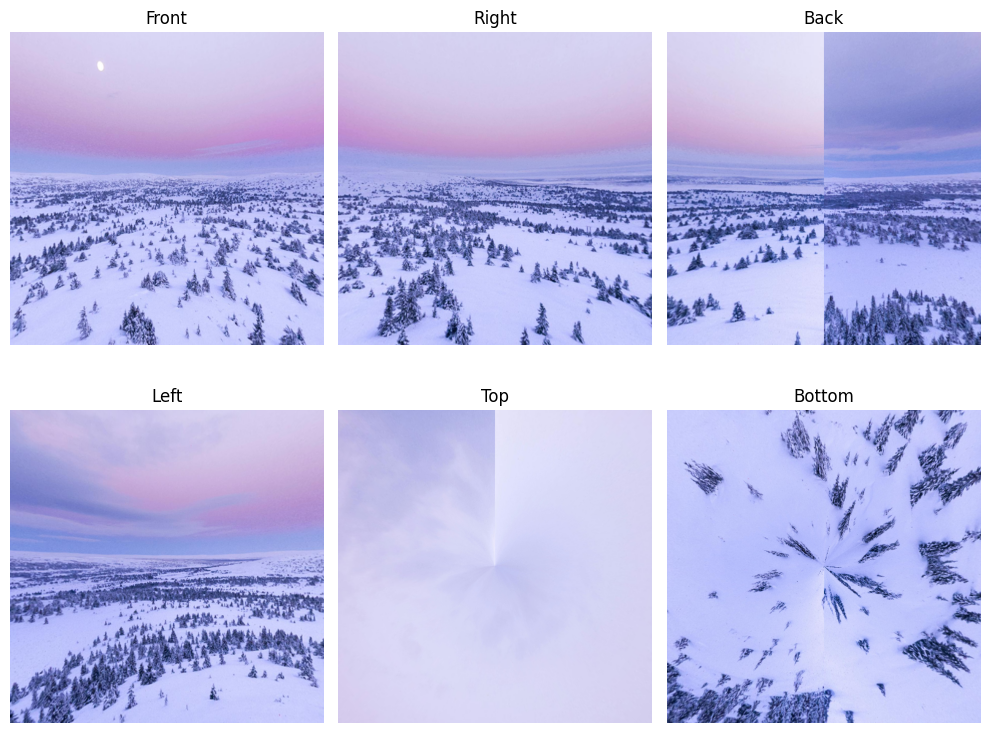

In [8]:
# Convert to cubemap
face_size = 512  # Size of each face
cubemap_faces = equirect_to_cubemap(panorama_img, face_size=face_size)

# Display cubemap faces
face_names = ['Front', 'Right', 'Back', 'Left', 'Top', 'Bottom']

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()

for i, (face, name) in enumerate(zip(cubemap_faces, face_names)):
    axes[i].imshow(face)
    axes[i].set_title(name)
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

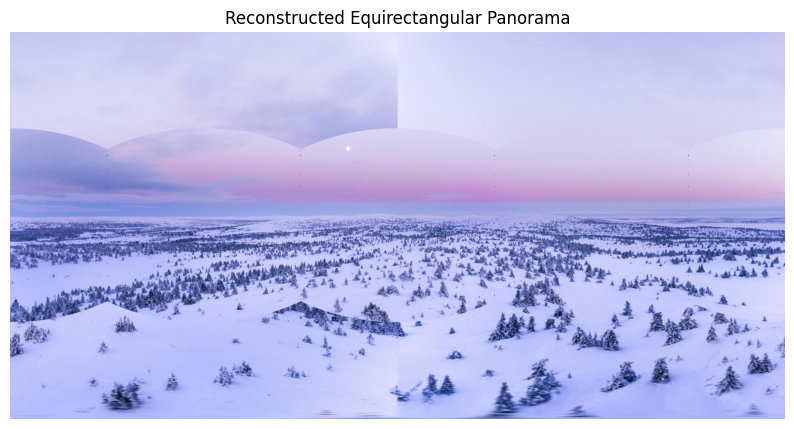

CPU times: user 44.1 s, sys: 155 ms, total: 44.2 s
Wall time: 44 s


In [9]:
%%time
# Convert back to equirectangular to validate the conversion
equirect_reconstructed = cubemap_to_equirect(cubemap_faces, output_height=1024, output_width=2048)

# Display reconstructed panorama
plt.figure(figsize=(10, 6))
plt.imshow(equirect_reconstructed.astype(np.uint8))
plt.title("Reconstructed Equirectangular Panorama")
plt.axis('off')
plt.show()

## 3. Loading Model Components

Let's load the pretrained model components from Stable Diffusion.

In [10]:
# Import model functions
from cubediff_models import load_sd_components, convert_attention_modules #, debug_convert_attention_modules # convert_to_inflated_attention

In [11]:
# Load model components
vae, text_encoder, tokenizer, unet = load_sd_components(
    model_id="runwayml/stable-diffusion-v1-5",
    use_sync_gn=True
)

Loading model components from runwayml/stable-diffusion-v1-5...
Converting VAE GroupNorm layers to SynchronizedGroupNorm...
Converted 52 GroupNorm layers in VAE


In [12]:
# Convert UNet to use inflated attention
# unet = convert_to_inflated_attention(unet)
# unet = convert_attention_modules(unet)
# unet = debug_convert_attention_modules(unet)

## 4. Testing the Synchronized GroupNorm and Inflated Attention

Now let's test the synchronized GroupNorm and inflated attention layers.

In [13]:
# Test the positional encoding
# Create random latents
batch_size = 1
faces = 6
channels = 4
height = width = 64  # Latent space size

latents = torch.randn(batch_size * faces, channels, height, width, device=device)

# Add positional encodings
latents_with_pos = add_cubemap_positional_encodings(latents, batch_size)

# Check shape
print(f"Original latents shape: {latents.shape}")
print(f"Latents with positional encodings shape: {latents_with_pos.shape}")

Original latents shape: torch.Size([6, 4, 64, 64])
Latents with positional encodings shape: torch.Size([6, 6, 64, 64])


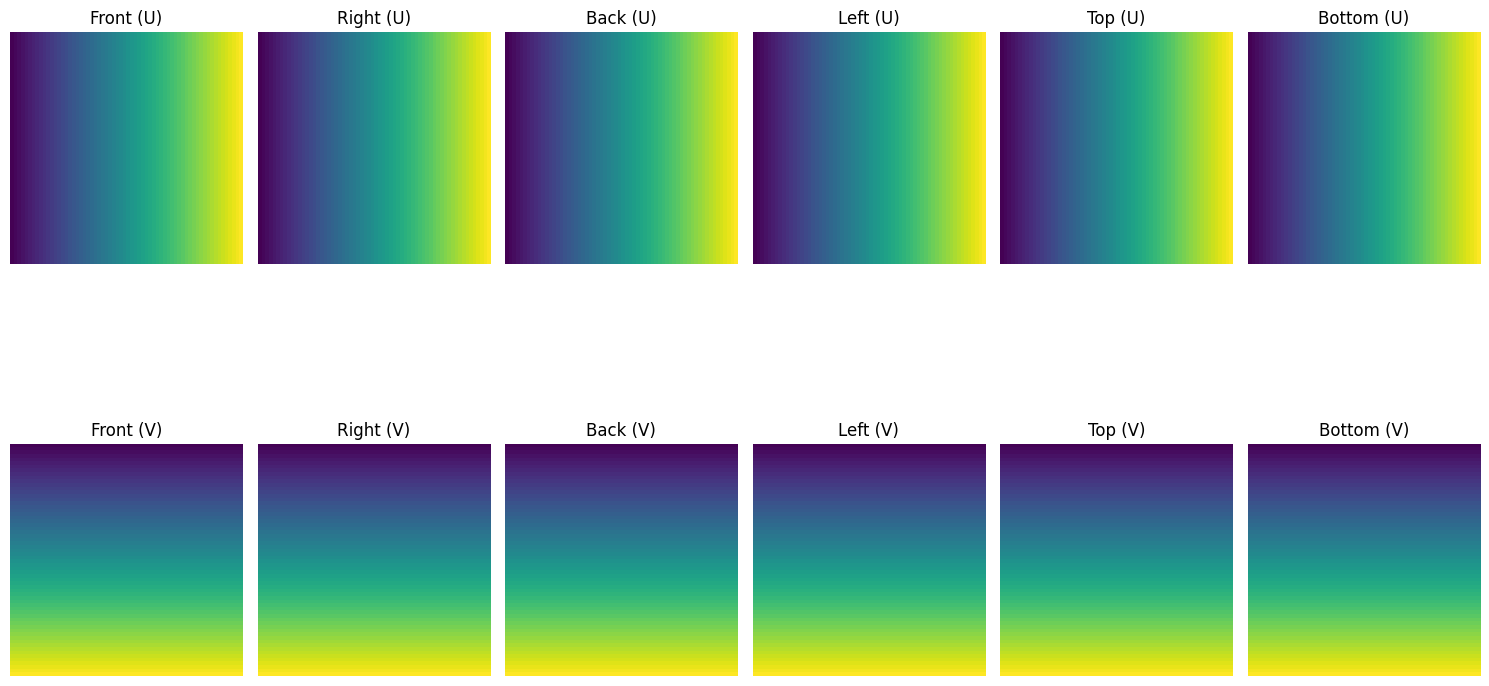

In [14]:
# Visualize positional encodings for one batch
pos_enc = latents_with_pos[0:6, channels:, :, :].cpu()

plt.figure(figsize=(15, 10))

face_names = ['Front', 'Right', 'Back', 'Left', 'Top', 'Bottom']

for i, name in enumerate(face_names):
    # U coordinate
    plt.subplot(2, 6, i+1)
    plt.imshow(pos_enc[i, 0].numpy(), cmap='viridis')
    plt.title(f"{name} (U)")
    plt.axis('off')
    
    # V coordinate
    plt.subplot(2, 6, i+7)
    plt.imshow(pos_enc[i, 1].numpy(), cmap='viridis')
    plt.title(f"{name} (V)")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 5. Running Inference

Now let's use the CubeDiff model to generate panoramas from text prompts.

In [15]:
# Import inference class
from cubediff_inference import CubeDiffInference

In [16]:
# Create scheduler
scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    num_train_timesteps=1000,
    clip_sample=False,
    prediction_type="epsilon"
)

In [17]:
%%time
# Create inference pipeline
pipeline = CubeDiffInference(
    vae=vae,
    unet=unet,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    scheduler=scheduler,
    device=device
)

CubeDiff pipeline initialized successfully
CPU times: user 4.45 ms, sys: 25 μs, total: 4.47 ms
Wall time: 4.31 ms


In [18]:
%%time
# Generate panorama from text prompt
prompt = "A beautiful mountain landscape at sunset with a lake in the foreground"
result = pipeline.generate(
    prompt=prompt,
    num_inference_steps=80,  # Reduced for faster inference
    guidance_scale=7.5,
    seed=42,
    return_faces=True
)

Starting panorama generation for prompt: 'A beautiful mountain landscape at sunset with a lake in the foreground'
Setting random seed: 42
Encoding text prompt...
Setting up classifier-free guidance with scale: 7.5
Using memory-efficient approach, processing each face independently...
Generating face 1/6
Setting up diffusion process with 80 steps...
Starting diffusion process for face 1...
Face 1, diffusion step 1/80 (1.2%)


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacty of 22.06 GiB of which 5.12 MiB is free. Process 51080 has 22.05 GiB memory in use. Of the allocated memory 21.33 GiB is allocated by PyTorch, and 503.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
%%time
# Print result shape for debugging
print("Result type:", type(result))
if isinstance(result, torch.Tensor):
    print("Result shape:", result.shape)

# Visualize all aspects (individual faces, panorama, and 3D cube)
viz.visualize_all(result, prompt)

NameError: name 'result' is not defined

In [20]:
type(result), result.shape

NameError: name 'result' is not defined

In [ ]:
# Display individual cubemap faces
face_names = ['Front', 'Right', 'Back', 'Left', 'Top', 'Bottom']
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, (face, name) in enumerate(zip(result["faces"], face_names)):
    axes[i].imshow(face)
    axes[i].set_title(name)
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

## 6. Image-to-Panorama Generation

Let's test generating a panorama from a single input image.

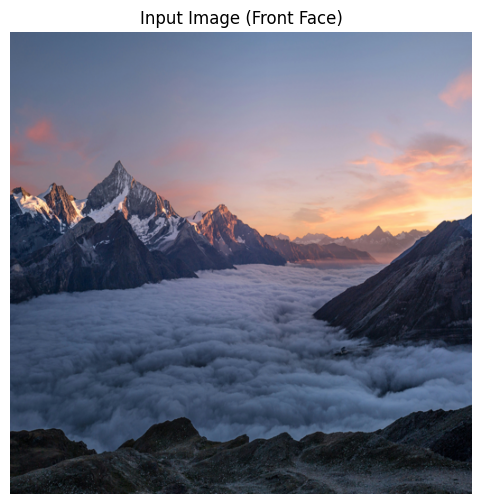

In [18]:
# Download a sample image or use your own
sample_img_url = "https://images.unsplash.com/photo-1506905925346-21bda4d32df4"
response = requests.get(sample_img_url)
input_img = Image.open(BytesIO(response.content))

# Resize for faster processing
input_img = input_img.resize((512, 512))

# Display sample input image
plt.figure(figsize=(6, 6))
plt.imshow(input_img)
plt.title("Input Image (Front Face)")
plt.axis('off')
plt.show()

In [19]:
%%time
# Generate panorama from input image
prompt = "A majestic mountain range with a clear blue sky"
result_img2pano = pipeline.generate_from_image(
    image=input_img,
    prompt=prompt,
    num_inference_steps=30,  # Reduced for faster inference
    guidance_scale=7.5,
    seed=42
)

AttributeError: 'CubeDiffInference' object has no attribute 'generate_from_image'

In [ ]:
# Display generated panorama
plt.figure(figsize=(15, 7.5))
plt.imshow(result_img2pano["panorama"])
plt.title(f"Generated Panorama from Input Image: {prompt}")
plt.axis('off')
plt.show()

## 7. Saving and Loading Models

Let's demonstrate how to save and load trained models.

In [ ]:
# Create output directory
os.makedirs("./output/checkpoints", exist_ok=True)

# Save UNet (pretending we've trained it)
unet.save_pretrained("./output/checkpoints/unet_example")
print("Saved UNet to ./output/checkpoints/unet_example")

In [ ]:
# Load saved UNet
from diffusers import UNet2DConditionModel

loaded_unet = UNet2DConditionModel.from_pretrained("./output/checkpoints/unet_example")
print("Loaded UNet from checkpoint")

# Convert to inflated attention
# loaded_unet = convert_to_inflated_attention(loaded_unet)
loaded_unet = convert_attention_modules(loaded_unet)

## 8. Memory Optimization for L4 GPUs

Let's explore memory optimization techniques for L4 GPUs.

In [ ]:
# Import optimization functions
from cubediff_optimization import optimize_for_vertex_ai, enable_memory_efficient_attention

In [ ]:
# Get optimized settings for Vertex AI
settings = optimize_for_vertex_ai(num_gpus=4, memory_per_gpu=22)
print("Optimized settings for Vertex AI:")
for key, value in settings.items():
    print(f"  {key}: {value}")

In [ ]:
# Enable memory-efficient attention
if torch.cuda.is_available():
    unet = enable_memory_efficient_attention(unet)
    unet.enable_gradient_checkpointing()
    print("Enabled memory optimization techniques")

## 9. Monitoring Memory Usage

Let's create a function to monitor GPU memory usage during training and inference.

In [ ]:
def print_gpu_memory_stats():
    """Print GPU memory usage statistics"""
    if not torch.cuda.is_available():
        print("CUDA not available")
        return
    
    for i in range(torch.cuda.device_count()):
        total_memory = torch.cuda.get_device_properties(i).total_memory / 1e9  # GB
        reserved_memory = torch.cuda.memory_reserved(i) / 1e9  # GB
        allocated_memory = torch.cuda.memory_allocated(i) / 1e9  # GB
        free_memory = total_memory - reserved_memory  # GB
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Total memory: {total_memory:.2f} GB")
        print(f"  Reserved memory: {reserved_memory:.2f} GB")
        print(f"  Allocated memory: {allocated_memory:.2f} GB")
        print(f"  Free memory: {free_memory:.2f} GB")
        print("---")

In [ ]:
# Monitor memory usage before and after model loading
if torch.cuda.is_available():
    # Clear cache
    torch.cuda.empty_cache()
    print("Initial memory usage:")
    print_gpu_memory_stats()
    
    # Load model components to device
    vae = vae.to(device)
    text_encoder = text_encoder.to(device)
    unet = unet.to(device)
    
    print("\nMemory usage after loading models:")
    print_gpu_memory_stats()

## 10. Benchmarking Inference Speed

Let's benchmark the inference speed for different numbers of denoising steps.

In [ ]:
import time

def benchmark_inference(pipeline, prompt, steps_list=[10, 20, 30, 50]):
    """Benchmark inference speed for different numbers of steps"""
    results = {}
    
    for steps in steps_list:
        print(f"Testing with {steps} steps...")
        torch.cuda.empty_cache()
        
        # Run once to warm up
        _ = pipeline.generate(
            prompt=prompt,
            num_inference_steps=steps,
            guidance_scale=7.5,
            seed=42
        )
        
        # Measure time for 3 runs
        times = []
        for i in range(3):
            torch.cuda.synchronize()
            start_time = time.time()
            
            _ = pipeline.generate(
                prompt=prompt,
                num_inference_steps=steps,
                guidance_scale=7.5,
                seed=42+i
            )
            
            torch.cuda.synchronize()
            end_time = time.time()
            times.append(end_time - start_time)
        
        avg_time = sum(times) / len(times)
        results[steps] = avg_time
        print(f"  Average time: {avg_time:.2f} seconds")
    
    return results

In [ ]:
# Run benchmarks (comment out if not needed, as this takes time)
if torch.cuda.is_available():
    prompt = "A beautiful mountain landscape at sunset"
    benchmark_results = benchmark_inference(pipeline, prompt, steps_list=[10, 20, 30])
    
    # Plot results
    plt.figure(figsize=(10, 6))
    steps = list(benchmark_results.keys())
    times = list(benchmark_results.values())
    plt.bar(steps, times)
    plt.xlabel('Number of Denoising Steps')
    plt.ylabel('Inference Time (seconds)')
    plt.title('Inference Time vs. Number of Denoising Steps')
    plt.show()

## 11. Creating a Sample Dataset

Let's create a small example dataset for testing.

In [ ]:
# Import dataset creation function
from cubediff_utils import create_example_dataset

In [ ]:
# Create a small example dataset
create_example_dataset(num_samples=2, output_dir="./example_data")

## 12. Testing Dataset Loading

Let's test the dataset loading and visualization.

In [ ]:
# Import dataset class
from cubediff_dataset import CubemapDataset

In [ ]:
# Get panorama paths and prompts
panorama_paths = [os.path.join("./example_data/panoramas", f) for f in os.listdir("./example_data/panoramas") 
                  if f.endswith(('.jpg', '.jpeg', '.png'))]

with open("./example_data/prompts.txt", 'r') as f:
    prompts = [line.strip() for line in f.readlines()]

# Make sure we have a prompt for each panorama
if len(prompts) < len(panorama_paths):
    prompts = prompts * (len(panorama_paths) // len(prompts) + 1)
prompts = prompts[:len(panorama_paths)]

# Create transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create dataset
dataset = CubemapDataset(
    panorama_paths=panorama_paths,
    text_prompts=prompts,
    face_size=512,
    transform=transform
)

print(f"Dataset size: {len(dataset)}")

In [ ]:
# Visualize a sample from the dataset
sample = dataset[0]
cubemap_tensor = sample["cubemap"]
prompt = sample["prompt"]

print(f"Prompt: {prompt}")
print(f"Cubemap tensor shape: {cubemap_tensor.shape}")

# Convert tensor to image for visualization
cubemap_images = [tensor.permute(1, 2, 0).numpy() for tensor in cubemap_tensor]

# Display cubemap faces
face_names = ['Front', 'Right', 'Back', 'Left', 'Top', 'Bottom']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (face, name) in enumerate(zip(cubemap_images, face_names)):
    axes[i].imshow(face)
    axes[i].set_title(name)
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

## 13. Conclusion

This notebook has demonstrated the key components of the CubeDiff architecture:

1. The conversion between equirectangular and cubemap representations
2. The synchronized GroupNorm for color consistency across faces
3. The inflated attention layers for cross-view awareness
4. The inference pipeline for generating panoramas from text or images
5. Memory optimization techniques for the Vertex AI environment

The CubeDiff architecture represents a significant advancement in 360° panorama generation, providing high-quality, consistent results with minimal architectural modifications to existing diffusion models.

To train your own CubeDiff model, use the provided `train_cubediff.py` script with a dataset of panoramic images. For inference with a pretrained model, use the `run_inference.py` script, which supports both text-to-panorama and image-to-panorama generation.

For more details, refer to the documentation in the README file and the original paper "CubeDiff: Repurposing Diffusion-Based Image Models for Panorama Generation".